code from [here](https://github.com/google-deepmind/ferminet?tab=readme-ov-file#pretrained-models)

## Theory 1: Running binary

In [7]:
!ferminet --config ferminet/configs/ne.py --config.optim.iterations 1000 --config.log.save_path runs/ne_1000

/home/johannes/.conda/envs/ferminet/bin/ferminet:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('ferminet==0.2')
I0130 11:10:03.209882 128561009378112 ferminet:34] System config:

batch_size: 256
config_module: ferminet.base_config
debug:
  check_nan: false
  deterministic: false
log:
  features: false
  local_energies: false
  restore_path: ''
  save_frequency: 10.0
  save_path: runs/ne_1000
  stats_frequency: 1
  walkers: false
mcmc:
  adapt_frequency: 100
  blocks: 1
  burn_in: 100
  init_means: !!python/tuple []
  init_width: 1.0
  move_width: 0.02
  num_leapfrog_steps: 10
  scale_by_nuclear_distance: false
  steps: 10
  use_hmc: false
network:
  bias_orbitals: false
  complex: false
  determinants: 16
  ferminet:
    electron_nuclear_aux_dims: !!python/tuple []
    hidden_dims: !!python/tuple
    - &id001 !!python/tuple
      - 256
      - 32
    - *id001
    - *id001
 

In [69]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
ne_results = pd.read_csv("runs/ne_1000/train_stats.csv", index_col="step")
ne_results["ewstddev"] = np.sqrt(ne_results["ewvar"]) # compute std dev from variance
ne_results.head()

,energy,ewmean,ewvar,pmove,ewstddev
step,,,,,
0,-59.430088,-59.430088,-0.000000,0.923828,-0.000000
1,-60.200474,-59.507126,0.053414,0.913281,0.231116
2,-60.759552,-59.632370,0.189244,0.907813,0.435022
3,-60.814760,-59.750610,0.296144,0.918750,0.544191
4,-60.647830,-59.840332,0.338980,0.902344,0.582220


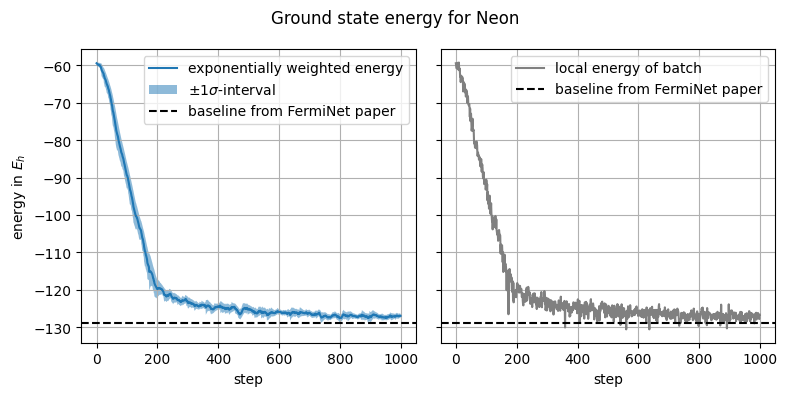

In [110]:
fig, (lax, rax) = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.suptitle("Ground state energy for Neon")
# plot smoothed values on the left
ne_results["ewmean"].plot.line(label="exponentially weighted energy", ax=lax)
mu, sig = ne_results["ewmean"], ne_results["ewstddev"]
lax.fill_between(ne_results.index, mu - sig, mu + sig, alpha=0.5, label=r"$\pm1\sigma$-interval")
lax.axhline(-128.9366, label="baseline from FermiNet paper", c="k", ls="--")
lax.set_ylabel(r"energy in $E_h$")
lax.grid(True)
lax.legend()
# plot batch values on the right
ne_results["energy"].plot.line(label="local energy of batch", c="gray", ax=rax)
rax.axhline(-128.9366, label="baseline from FermiNet paper", c="k", ls="--")
rax.grid(True)
rax.legend()
fig.tight_layout();

## Theory 2: Using prebuilt models

In [1]:
import numpy as np
import jax
from functools import partial
from ferminet import networks, train, envelopes, loss, hamiltonian
import os
import matplotlib.pyplot as plt

In [2]:
path = "models/neon/"
os.listdir(path)

['walkers.npy', 'params.npz', 'geometry.npz']

In [4]:
with open(path + 'params.npz', 'rb') as f:
  params = dict(np.load(f, allow_pickle=True))
  params = params['arr_0'].tolist()

with open(path + 'walkers.npy', 'rb') as f:
  data = np.load(f)

with open(path + 'geometry.npz', 'rb') as f:
  geometry = dict(np.load(f, allow_pickle=True))

In [5]:
# print parameter shapes
jax.tree_util.tree_map(
  lambda p: p.shape,
  dict(params=params, data=data, geometry=geometry),
)

{'data': (4096, 30),
 'geometry': {'atoms': (1, 3), 'charges': (1,), 'spins': (2,)},
 'params': {'double': [{'b': (32,), 'w': (4, 32)},
   {'b': (32,), 'w': (32, 32)},
   {'b': (32,), 'w': (32, 32)}],
  'envelope': [{'pi': (1, 80), 'sigma': (1, 80)},
   {'pi': (1, 80), 'sigma': (1, 80)}],
  'orbital': [{'w': (256, 80)}, {'w': (256, 80)}],
  'single': [{'b': (256,), 'w': (20, 256)},
   {'b': (256,), 'w': (832, 256)},
   {'b': (256,), 'w': (832, 256)},
   {'b': (256,), 'w': (832, 256)}]}}

In [6]:
geometry["atoms"]

array([[0., 0., 0.]], dtype=float32)

In [12]:
# TODO: verify
nspins = tuple(geometry["spins"])
nspins # alpha and beta electrons

(5, 5)

In [21]:
jax.tree_util.tree_map(
  lambda p: p.shape,
  #dict(params=params, data=data, geometry=geometry),
  params,
)

{'double': [{'b': (32,), 'w': (4, 32)},
  {'b': (32,), 'w': (32, 32)},
  {'b': (32,), 'w': (32, 32)}],
 'envelope': [{'pi': (1, 80), 'sigma': (1, 80)},
  {'pi': (1, 80), 'sigma': (1, 80)}],
 'orbital': [{'w': (256, 80)}, {'w': (256, 80)}],
 'single': [{'b': (256,), 'w': (20, 256)},
  {'b': (256,), 'w': (832, 256)},
  {'b': (256,), 'w': (832, 256)},
  {'b': (256,), 'w': (832, 256)}]}

In [20]:
signed_network = networks.make_fermi_net(
  nspins,
  geometry["charges"], # charges (atomic number)
  envelope=None, # by default, an isotropic envelope is constructed
  full_det=False,
)
network = lambda *args: signed_network.apply(*args)[1]
#batched_network = jax.vmap(network, (None, 0), 0)
#signed_network.apply()
random_net_params = signed_network.init(jax.random.PRNGKey(42))
jax.tree_util.tree_map(
  lambda p: p.shape,
  #dict(params=params, data=data, geometry=geometry),
  random_net_params,
)

{'envelope': [{'pi': (1, 80), 'sigma': (1, 80)},
  {'pi': (1, 80), 'sigma': (1, 80)}],
 'layers': {'input': {},
  'streams': [{'double': {'b': (32,), 'w': (4, 32)},
    'single': {'b': (256,), 'w': (20, 256)}},
   {'double': {'b': (32,), 'w': (32, 32)},
    'single': {'b': (256,), 'w': (832, 256)}},
   {'single': {'b': (256,), 'w': (832, 256)}}]},
 'orbital': [{'w': (256, 80)}, {'w': (256, 80)}]}

In [ ]:
signed_network.apply(
  random_net_params,
  
  nspins,
  geometry["atoms"],
  geometry["charges"],
)

In [66]:
local_energy_fn = hamiltonian.local_energy(
  network,
  geometry["charges"],
  nspins,
)
local_energy_fn

<function ferminet.hamiltonian.local_energy.<locals>._e_l(params: Union[jax.Array, Iterable[ForwardRef('ParamTree')], MutableMapping[Any, ForwardRef('ParamTree')]], key: jax.Array, data: ferminet.networks.FermiNetData) -> Tuple[jax.Array, Optional[jax.Array]]>

In [67]:
loss_fn = loss.make_loss(
  network,
  local_energy_fn, 
  clip_local_energy=5., # from prebuilt models example
)
loss_fn

In [69]:
net_data = networks.FermiNetData(
  positions=data[0][None,...],
  spins=geometry["spins"][None,...],
  atoms=geometry["atoms"][None,...],
  charges=geometry["charges"][None,...],
)

In [74]:
key = jax.random.PRNGKey(42)
loss_fn(params, key, net_data)

KeyError: 'layers'

In [10]:
signed_network = partial(networks, envelope_type='isotropic', full_det=False, **geometry)
# networks.fermi_net gives the sign/log of the wavefunction. We only care about the latter.
network = lambda p, x: signed_network(p, x)[1]
batch_network = jax.vmap(network, (None, 0), 0)
loss = train.make_loss(network, batch_network, geometry['atoms'], geometry['charges'], clip_local_energy=5.0)

TypeError: the first argument must be callable

In [11]:
networks.make_fermi_net

<function ferminet.networks.make_fermi_net(nspins: Tuple[int, int], charges: jax.Array, *, ndim: int = 3, determinants: int = 16, states: int = 0, envelope: Optional[ferminet.envelopes.Envelope] = None, feature_layer: Optional[ferminet.networks.FeatureLayer] = None, jastrow: Union[str, ferminet.jastrows.JastrowType] = <JastrowType.NONE: 1>, complex_output: bool = False, bias_orbitals: bool = False, full_det: bool = True, rescale_inputs: bool = False, hidden_dims: Tuple[Tuple[int, int], ...] = ((256, 32), (256, 32), (256, 32)), use_last_layer: bool = False, separate_spin_channels: bool = False, schnet_electron_electron_convolutions: Tuple[int, ...] = (), electron_nuclear_aux_dims: Tuple[int, ...] = (), nuclear_embedding_dim: int = 0, schnet_electron_nuclear_convolutions: Tuple[int, ...] = ()) -> ferminet.networks.Network>

In [12]:
print("\n".join(dir(networks)))

Any
ApplyLayersFn
BaseNetworkOptions
FeatureApply
FeatureInit
FeatureLayer
FeatureLayerType
FermiLayers
FermiNetData
FermiNetLike
FermiNetOptions
InitFermiNet
InitLayersFn
Iterable
LogFermiNetLike
MakeFeatureLayer
Mapping
MutableMapping
Network
Optional
OrbitalFnLike
Param
ParamTree
Protocol
Sequence
Tuple
Union
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__spec__
_combine_spin_pairs
_split_spin_pairs
attr
chex
construct_input_features
construct_symmetric_features
enum
envelopes
functools
jastrows
jax
jnp
make_fermi_net
make_fermi_net_layers
make_ferminet_features
make_orbitals
make_schnet_convolution
make_schnet_electron_nuclear_convolution
make_state_matrix
make_total_ansatz
network_blocks
